## Modes in bent and angled waveguides

Here, we illustrate how we can use the `ModeSource` and `ModeMonitor` objects to study modes in bent waveguides.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# tidy3D import
import tidy3d as td
from tidy3d import web
from tidy3d.plugins import ModeSolver


[20:09:50] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=307285;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=638237;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#101\101]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.10.0rc2                                                 ]8;id=106573;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=125052;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#116\116]8;;\

### Bent waveguide setup

First, we will study mode injection and decomposition in a microring. We start by defining various simulation parameters, and the structures that enter the simulation. We simulate a silicon ring on a silicon oxide substrate, and the ring is defined using two Cylinders.

In [2]:
# Unit length is micron.
wg_height = 0.22
wg_width = 0.9
# Radius of the simulated ring
radius = 2

# Waveguide and substrate materials
mat_wg = td.Medium(permittivity=3.48**2)
mat_sub = td.Medium(permittivity=1.45**2)

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0 / lambda0
fwidth = freq0 / 10

# Simulation size inside the PML along propagation direction
sim_length = radius + 1.5

# Simulation domain size, resolution and total run time
sim_size = [sim_length, 2 * (radius + 1.5), 3]
run_time = 20 / fwidth
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lambda0)

# Substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sim_size[2]],
        size=[td.inf, td.inf, 2 * sim_size[2] - wg_height],
    ),
    medium=mat_sub,
)

# The ring is made by two cylinders
cyl1 = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, 0],
        radius=radius - wg_width / 2,
        length=wg_height,
        axis=2,
    ),
    medium=td.Medium(),
)
cyl2 = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, 0],
        radius=radius + wg_width / 2,
        length=wg_height,
        axis=2,
    ),
    medium=mat_wg,
)


### Modal planes in bent waveguides

As usual, when initializing `ModeSource` and `ModeMonitor` objects, one of the three values of the `size` parameter must be zero. In this example, we also need to define the axis of the bend and the radius of the curvature. The definitions are schematically illustrated in the image below. The bend axis is the axis normal to the plane in which the bend lies, (`'z'` in the diagram below). In the mode specification, it is defined *locally* for the mode plane as one of the two axes tangential to the plane. In the case of bends that lie in the `xy`-plane, the mode plane would be either in `xz` or in `yz`, so in both cases the correct setting is `bend_axis=1`, selecting the global `z`. The bend radius is counted from the center of the mode plane to the center of the curvature, along the tangential axis perpendicular to the bend axis. This radius can also be negative, if the center of the mode plane is smaller than the center of the bend, which is what we will encounter in this example. Finally, we note that the `'forward'` and `'backward'` direction parameter can still be used to distinguish between the two propagation directions as in regular modal sources and monitors.

<img src="img/ring_modes.png" width=800>

In [3]:
# xy-plane frequency-domain field monitor; slightly offset in z for better structure viz below
field_mnt = td.FieldMonitor(
    center=[0, 0, 0.05], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)

# Flux monitor along the ring propagation direction
flux_mnt = td.FluxMonitor(
    center=[0, radius, 0], size=[0, 3, 2], freqs=[freq0], name="flux"
)


### Running the simulation 

First, we visualize the simulation to make sure we have set up the device correctly. We will use `'absorber'` boundaries along the x-direction, because these boundaries work better than PML for structures which are not translationally invariant along the boundary normal direction.

[20:09:51] WARNING  No sources in simulation.                                                     ]8;id=847587;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=506622;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#584\584]8;;\

<Axes: title={'center': 'cross section at x=0.00'}, xlabel='y', ylabel='z'>

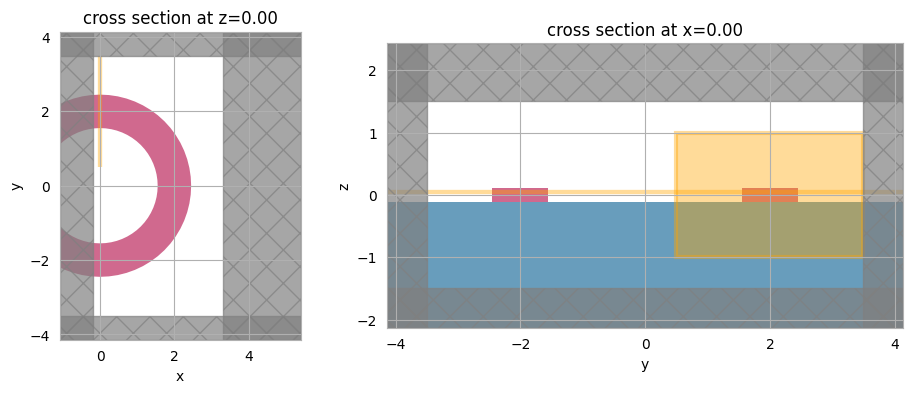

In [4]:
# Simulation
sim = td.Simulation(
    center=[sim_length / 2 - 0.2, 0, 0],
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, cyl2, cyl1],
    sources=[],
    monitors=[field_mnt, flux_mnt],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(), y=td.Boundary.pml(), z=td.Boundary.pml()
    ),
)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.plot(z=0, ax=ax1)
sim.plot(x=0, ax=ax2)


Next, we can compute the source modes to make sure that we inject the desired mode. When a bend radius $R$ is used, the effective index $n$ returned by the solver is such that the field evolves as $e^{i n k_0 R \phi}$, with $\phi$ the polar angle and $k_0 = \omega/c$. This definition is such that in the limit of infinite $R$, the effective index approaches that of a straight waveguide with the same cross-section. Based on our discussion and diagram above, we set the `bend_axis` to `1`, and the `bend_radius` at the position of the source is negative.

[20:09:53] WARNING  Mode field at frequency index 0, mode index 2 does not decay at the plane    ]8;id=469610;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=929663;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/plugins/mode/mode_solver.py#354\354]8;;\
                    boundaries.                                                                                    

           WARNING  Mode field at frequency index 0, mode index 3 does not decay at the plane    ]8;id=320769;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=131134;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/plugins/mode/mode_solver.py#354\354]8;;\
                    boundaries.                                                                                    

           WARNING  No sources in simulation.                                                     ]8;id=1784;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=873498;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#584\584]8;;\

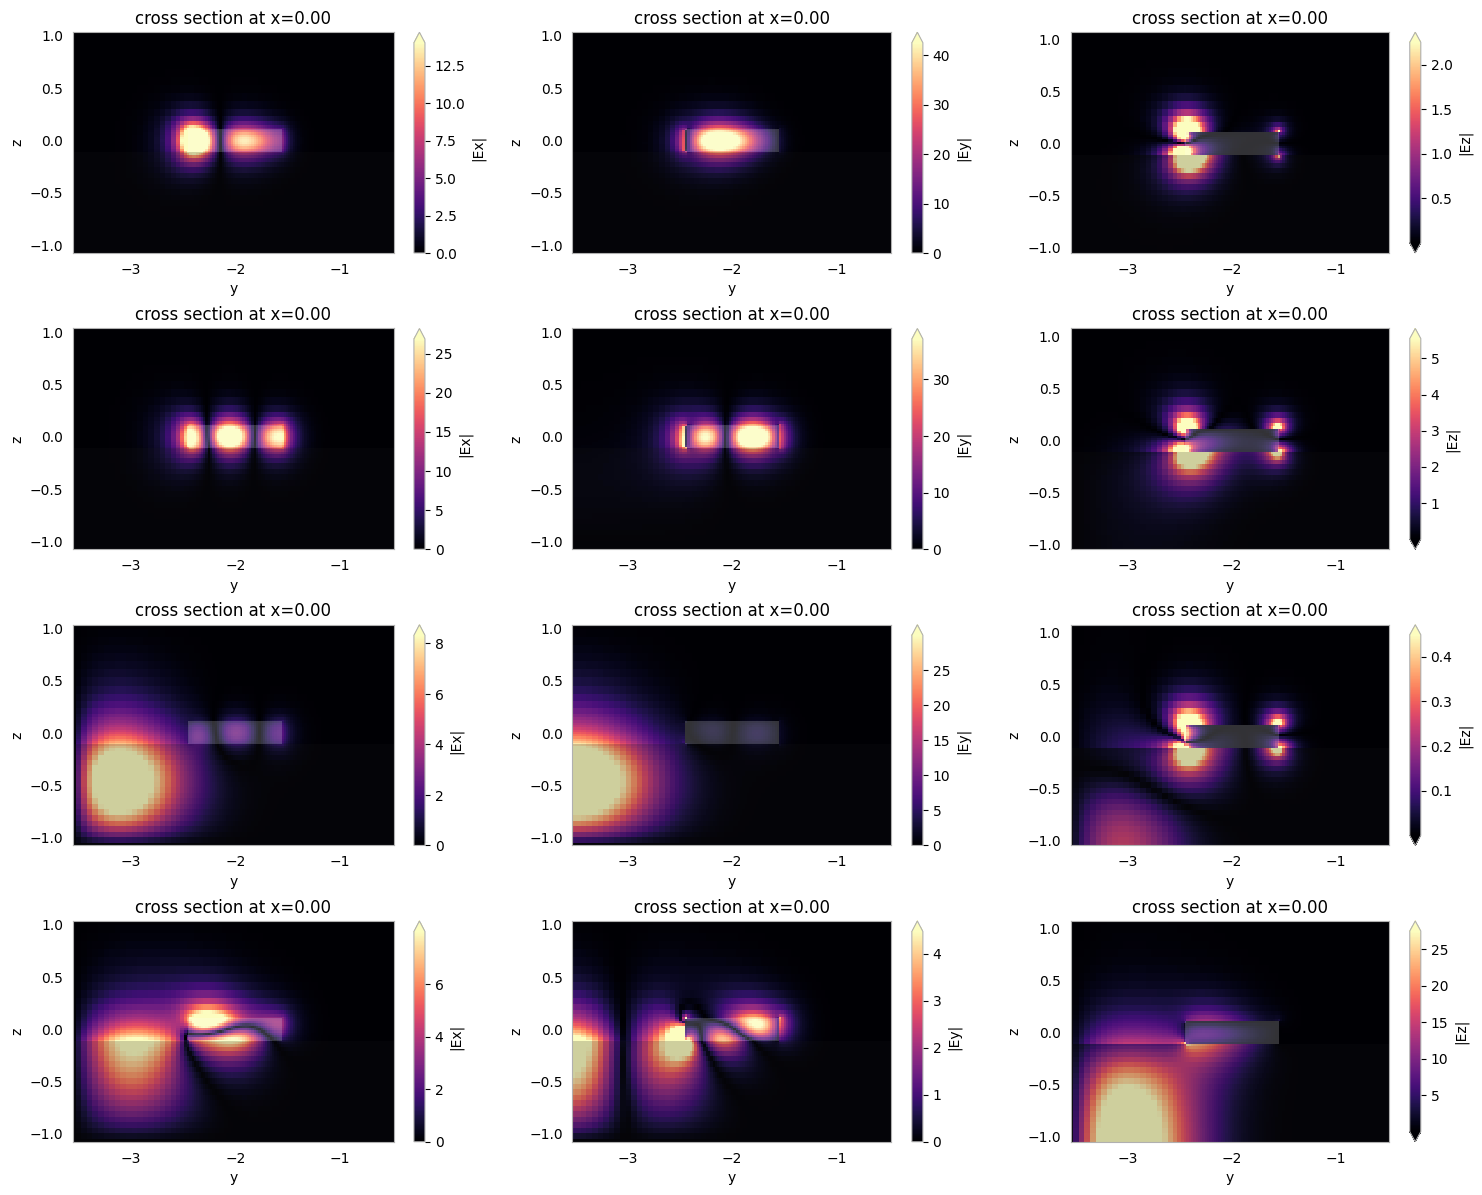

In [5]:
# Modal source plane
source_plane = td.Box(center=[0, -radius, 0], size=[0, 3, 2])

num_modes = 4
# NB: negative radius since the plane position is at y=-radius
mode_spec = td.ModeSpec(num_modes=num_modes, bend_radius=-radius, bend_axis=1)
ms = ModeSolver(simulation=sim, plane=source_plane, freqs=[freq0], mode_spec=mode_spec)

modes = ms.solve()
f, axes = plt.subplots(num_modes, 3, tight_layout=True, figsize=(15, 12))
for axe, mode_index in zip(axes, range(num_modes)):
    for ax, field_name in zip(axe, ("Ex", "Ey", "Ez")):
        ms.plot_field(field_name, "abs", f=freq0, mode_index=mode_index, ax=ax)


Note that the last two of the computed modes are unphysical. The fundamental mode looks like what we would expect, and we will use that mode for injection. Below, we also define a mode monitor, which is situated radially from the mode source, and so we use a positive value for the bend radius.

In [6]:
# Mode source directly exported from the mode solver above
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_src = ms.to_source(source_time=source_time, mode_index=0, direction="+")

# Mode monitor after one-half round-trip around the ring; NB: positive radius
mode_mnt = td.ModeMonitor(
    center=[0, radius, 0],
    size=[0, 3, 2],
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=2, bend_radius=radius, bend_axis=1),
    name="modes",
)

sim = sim.copy(update=dict(sources=[mode_src]))
sim = sim.copy(update=dict(monitors=[field_mnt, flux_mnt, mode_mnt]))


In [7]:
sim_data = web.run(sim, task_name="ring_mode", path="data/sim_data.hdf5")


[20:10:11] INFO     Created task 'ring_mode' with task_id                                             ]8;id=962976;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=209594;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#136\136]8;;\
                    'fdve-b025f690-b9ec-4cbf-8d44-1b43fda124ecv1'.                                                 

Output()

[20:10:21] INFO     status = queued                                                                   ]8;id=804788;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=888266;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#265\265]8;;\

Output()

[20:10:26] INFO     status = preprocess                                                               ]8;id=971170;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=732700;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

[20:10:33] INFO     Maximum FlexUnit cost: 0.040. Use 'web.real_cost(task_id)' to get the billed      ]8;id=814312;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=56302;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#282\282]8;;\
                    FlexUnit cost after a simulation run.                                                          

           INFO     starting up solver                                                                ]8;id=414847;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=684570;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#286\286]8;;\

[20:10:44] INFO     running solver                                                                    ]8;id=327616;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=191006;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#296\296]8;;\

Output()

[20:10:49] INFO     early shutoff detected, exiting.                                                  ]8;id=826795;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=944047;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#309\309]8;;\

           INFO     status = postprocess                                                              ]8;id=626239;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=16530;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#326\326]8;;\

Output()

[20:10:54] INFO     status = success                                                                  ]8;id=19276;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=41973;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#333\333]8;;\

Output()

[20:11:05] INFO     loading SimulationData from data/sim_data.hdf5                                    ]8;id=120647;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=950800;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#507\507]8;;\

Finally, we visualize the results and verify that we get very close to unity transmission through the half-circle.

Transmission flux:        [0.99816906]
Flux in first two modes:  [0.99704068 0.00301029]


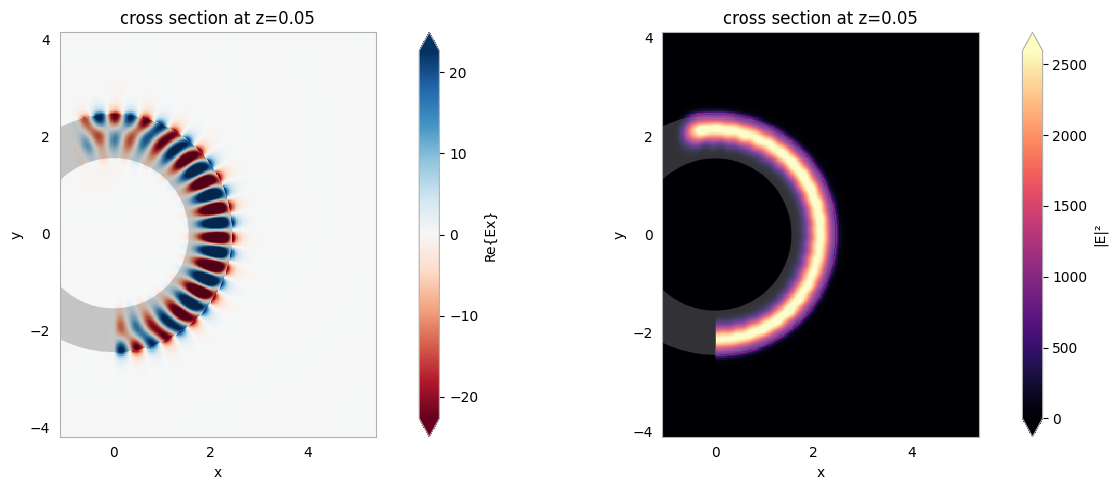

In [8]:
print("Transmission flux:       ", abs(sim_data["flux"].flux.data))
# note: 'backward' mode amplitude
mode_flux = abs(sim_data["modes"].amps.sel(direction="-")) ** 2
print("Flux in first two modes: ", np.array(mode_flux).ravel())

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
ax1 = sim_data.plot_field("field", "Ex", z=0.05, f=freq0, val="real", ax=ax1)
ax2 = sim_data.plot_field("field", "E", "abs^2", z=0.05, f=freq0, ax=ax2)


The transmission through the ring is very close to unity, and all the power is in the fundamental ring mode!

### Angled waveguide setup

`Mode` objects can also be set to inject and record propagation at a given angle with respect to the axis normal to the mode plane. The `angle_theta` and `angle_phi` parameters of `ModeSource` and `ModeMonitor` objects define the injection axis as illustrated in the figure below, with respect to the axis normal to the mode plane (`x` in the figure). Note that `angle_theta` must be smaller than $\pi/2$. To inject in the backward direction, we can still use the `direction` parameter as also shown in the figure. Similarly, the mode amplitudes computed in mode monitors are defined w.r.t. the `forward` and `backward` directions as illustrated.

<img src="img/mode_angled.png" width=500>

In [9]:
# Simulation size
sim_length = 3
sim_size = [sim_length, 5, 2]

# Define an angled waveguide as a PolySlab
wg_width = 0.45
theta = np.pi / 4
phi = np.pi

verts_x = np.array([-10, 10, 10, -10])
verts_y = verts_x * np.tan(theta)
verts_y[:2] -= wg_width / 2 / np.cos(theta)
verts_y[2:] += wg_width / 2 / np.cos(theta)
verts_y *= np.cos(phi)  # this only works for phi = 0 or pi
verts = np.stack((verts_x, verts_y), axis=1)
waveguide = td.Structure(
    geometry=td.PolySlab(vertices=verts, slab_bounds=(-wg_height / 2, wg_height / 2)),
    medium=mat_wg,
)

# Modal source
src_pos = 0
mode_spec = td.ModeSpec(num_modes=2, angle_theta=theta, angle_phi=phi)
msource = td.ModeSource(
    center=[src_pos, 0, 0],
    size=[0, 3, 2],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# Angled modal monitor
mnt_f = td.ModeMonitor(
    center=[
        sim_length / 2 - 0.5,
        (sim_length / 2 - 0.5) * np.tan(theta) * np.cos(phi),
        0,
    ],
    size=[0, 3, 2],
    freqs=[freq0],
    mode_spec=mode_spec,
    name="mnt_fwd",
)


We will once again use `'absorber'` boundaries along x, since the angled waveguide is not translationally invariant in that direction.

<Axes: title={'center': 'cross section at x=0.00'}, xlabel='y', ylabel='z'>

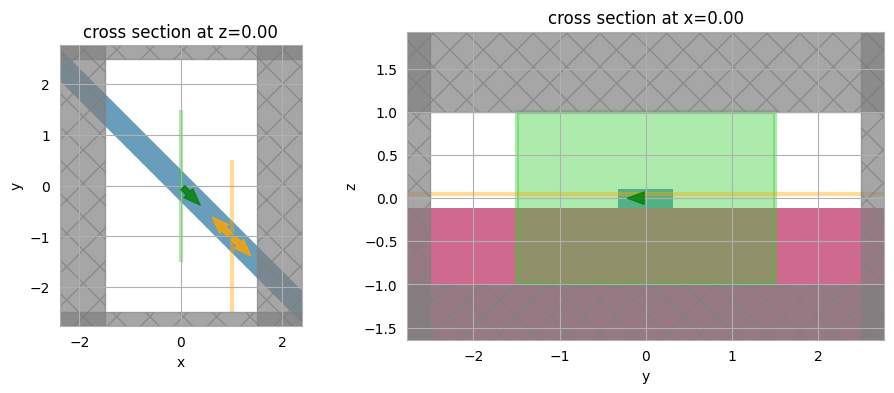

In [10]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[waveguide, substrate],
    sources=[msource],
    monitors=[field_mnt, mnt_f],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(), y=td.Boundary.pml(), z=td.Boundary.pml()
    ),
)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2.2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.plot(z=0, ax=ax1)
sim.plot(x=0, ax=ax2)


Examine the modes.

[20:11:21] WARNING  Mode field at frequency index 0, mode index 1 does not decay at the plane    ]8;id=44140;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=611001;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/plugins/mode/mode_solver.py#354\354]8;;\
                    boundaries.                                                                                    

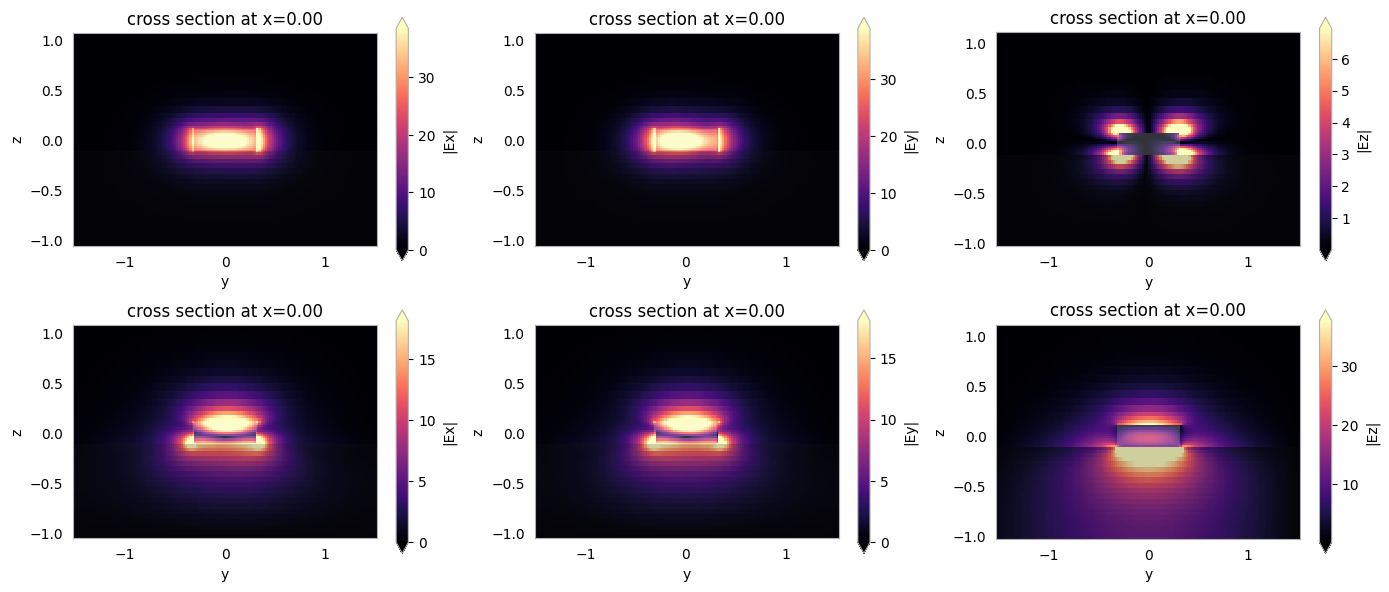

In [11]:
ms = ModeSolver(
    simulation=sim, plane=msource.geometry, mode_spec=mode_spec, freqs=[freq0]
)
modes = ms.solve()

f, axes = plt.subplots(mode_spec.num_modes, 3, tight_layout=True, figsize=(14, 6))
for axe, mode_index in zip(axes, range(mode_spec.num_modes)):
    for ax, field_name in zip(axe, ("Ex", "Ey", "Ez")):
        ms.plot_field(field_name, "abs", f=freq0, mode_index=mode_index, ax=ax)


Run the simulation and plot the results.

In [12]:
sim_data = web.run(sim, task_name="angled_waveguide", path="data/sim_data.hdf5")


[20:11:29] INFO     Created task 'angled_waveguide' with task_id                                      ]8;id=393362;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=828268;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#136\136]8;;\
                    'fdve-6eb1d455-3710-4ea7-8d13-4c1729b8c3bcv1'.                                                 

Output()

[20:11:33] INFO     status = queued                                                                   ]8;id=722798;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=359951;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#265\265]8;;\

Output()

[20:11:42] INFO     status = preprocess                                                               ]8;id=599424;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=926520;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

[20:11:48] INFO     Maximum FlexUnit cost: 0.027. Use 'web.real_cost(task_id)' to get the billed      ]8;id=473703;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=560784;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#282\282]8;;\
                    FlexUnit cost after a simulation run.                                                          

           INFO     starting up solver                                                                ]8;id=305157;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=83655;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#286\286]8;;\

[20:11:58] INFO     running solver                                                                    ]8;id=335624;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=744905;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#296\296]8;;\

Output()

[20:12:00] INFO     early shutoff detected, exiting.                                                  ]8;id=378952;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=540967;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#309\309]8;;\

           INFO     status = postprocess                                                              ]8;id=571117;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=576495;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#326\326]8;;\

Output()

[20:12:03] INFO     status = success                                                                  ]8;id=936440;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=332062;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#333\333]8;;\

Output()

[20:12:11] INFO     loading SimulationData from data/sim_data.hdf5                                    ]8;id=935067;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=584411;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#507\507]8;;\

Flux in first two modes:  [9.99422546e-01 6.07127860e-05]


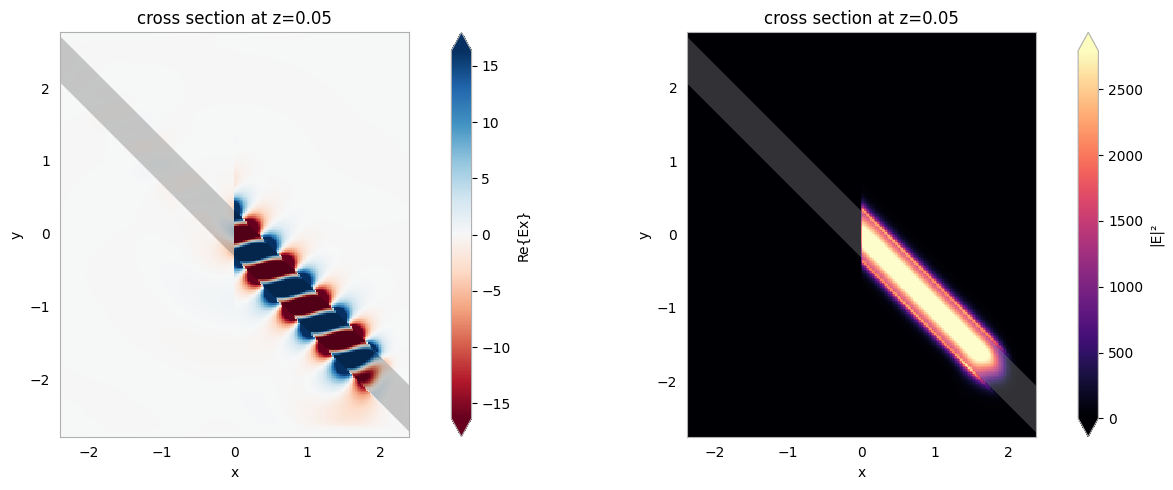

In [13]:
mode_flux = abs(sim_data["mnt_fwd"].amps.sel(direction="+")) ** 2
print("Flux in first two modes: ", np.array(mode_flux).ravel())

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
ax1 = sim_data.plot_field("field", "Ex", z=0.05, f=freq0, val="real", ax=ax1)
ax2 = sim_data.plot_field("field", "E", "abs^2", z=0.05, f=freq0, ax=ax2)


### Modes with both a bend and an angle

We can also compose the two functionalities to inject and record modes in a bent waveguide in which the bend curvature is not in the same plane as the mode plane. This is illustrated below, using the same ring simulation but with a modification of the position of the `ModeSource` and `ModeMonitor`.

<Axes: title={'center': 'cross section at x=0.00'}, xlabel='y', ylabel='z'>

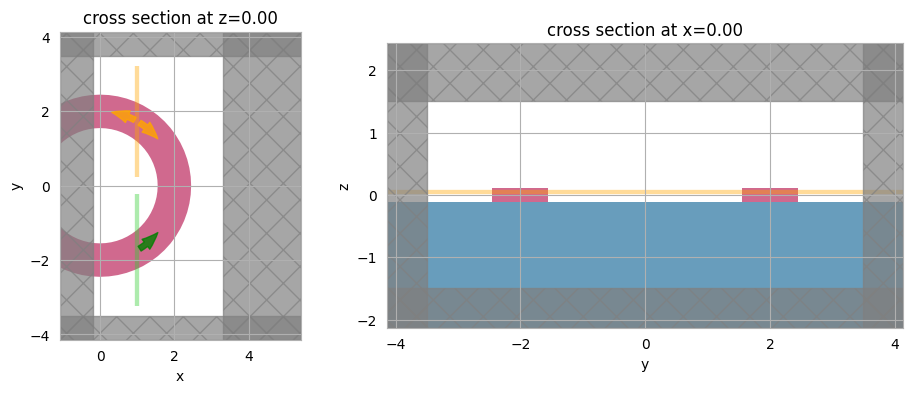

In [14]:
# offset the source and monitor position by 'angle' along the ring
angle = np.pi / 6

# Simulation size for the ring simulation
sim_length = radius + 1.5
sim_size = [sim_length, 2 * (radius + 1.5), 3]

# Note: angle_phi = 0, bend_radius = -r
src_angled = td.ModeSource(
    center=[radius * np.sin(angle), -radius * np.cos(angle), 0],
    size=[0, 3, 2],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=td.ModeSpec(
        angle_theta=angle,
        angle_phi=0,
        bend_radius=-radius,
        bend_axis=1,
    ),
)

# Note: angle_phi = np.pi, bend_radius = r
mnt_angled = td.ModeMonitor(
    center=[radius * np.sin(angle), radius * np.cos(angle), 0],
    size=[0, 3, 2],
    freqs=[freq0],
    mode_spec=td.ModeSpec(
        num_modes=2,
        angle_theta=angle,
        angle_phi=np.pi,
        bend_radius=radius,
        bend_axis=1,
    ),
    name="modes",
)

# Simulation
sim = td.Simulation(
    center=[sim_length / 2 - 0.2, 0, 0],
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, cyl2, cyl1],
    sources=[src_angled],
    monitors=[field_mnt, mnt_angled],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(), y=td.Boundary.pml(), z=td.Boundary.pml()
    ),
    subpixel=True,
)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.plot(z=0, ax=ax1)
sim.plot(x=0, ax=ax2)


In [15]:
sim_data = web.run(sim, task_name="angled_ring", path="data/sim_data.hdf5")


[20:12:15] INFO     Created task 'angled_ring' with task_id                                           ]8;id=746998;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=348676;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#136\136]8;;\
                    'fdve-0cdca9b3-f056-4cfd-aea2-f26816608b32v1'.                                                 

Output()

[20:12:18] INFO     status = queued                                                                   ]8;id=438459;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=466937;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#265\265]8;;\

Output()

[20:12:23] INFO     status = preprocess                                                               ]8;id=854892;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=748983;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

[20:12:28] INFO     Maximum FlexUnit cost: 0.040. Use 'web.real_cost(task_id)' to get the billed      ]8;id=732448;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=585416;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#282\282]8;;\
                    FlexUnit cost after a simulation run.                                                          

           INFO     starting up solver                                                                ]8;id=180467;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=688427;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#286\286]8;;\

[20:12:39] INFO     running solver                                                                    ]8;id=490558;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=852582;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#296\296]8;;\

Output()

[20:12:44] INFO     early shutoff detected, exiting.                                                  ]8;id=651431;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=214767;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#309\309]8;;\

           INFO     status = postprocess                                                              ]8;id=560552;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=917941;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#326\326]8;;\

Output()

[20:12:48] INFO     status = success                                                                  ]8;id=509132;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=730296;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#333\333]8;;\

Output()

[20:12:56] INFO     loading SimulationData from data/sim_data.hdf5                                    ]8;id=780061;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=724120;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#507\507]8;;\

Flux in first two modes:  [0.99921591 0.00216821]


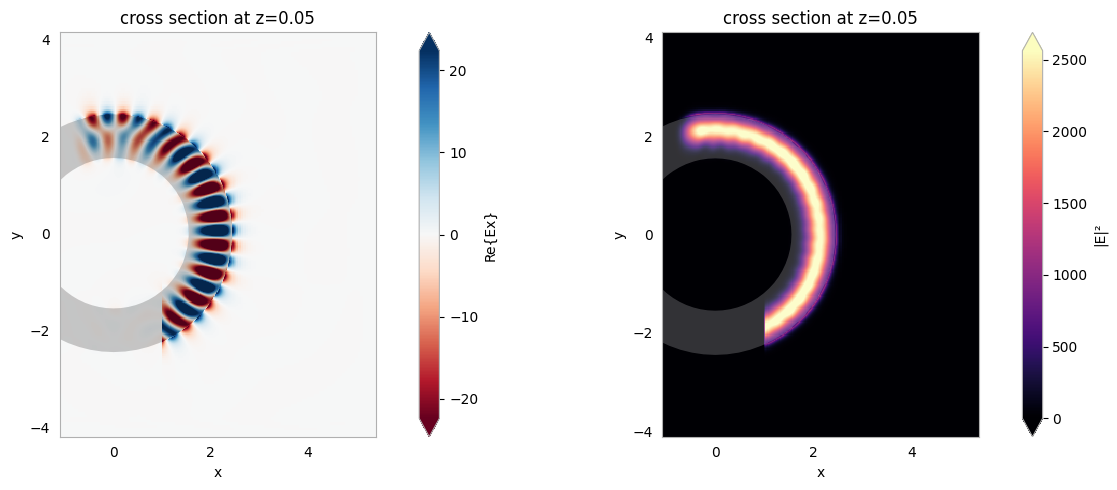

In [16]:
mode_flux = abs(sim_data["modes"].amps.sel(direction="-")) ** 2
print("Flux in first two modes: ", np.array(mode_flux).ravel())

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
ax1 = sim_data.plot_field("field", "Ex", z=0.05, f=freq0, val="real", ax=ax1)
ax2 = sim_data.plot_field("field", "E", "abs^2", z=0.05, f=freq0, ax=ax2)
